In [1]:
import pandas as pd

In [2]:
features = pd.read_csv('features.csv', index_col = 'Unnamed: 0')

In [3]:
features_test = pd.read_csv('test-1.csv', index_col = 'Unnamed: 0')

In [4]:
import xgboost as xgb

In [ ]:
from sklearn.cross_validation import KFold

In [ ]:
from sklearn.grid_search import GridSearchCV

In [20]:
my_col_mte = ['MCC','channel_type','trx_category','month','year','day','time','Alphabetic Code','convert-amount',
              'cl_activ','convert-amount-int','trx_category_new','cat_mcc','target_flag']

In [21]:
mean_columns = ['MCC','channel_type','trx_category','month','year','day','time','Alphabetic Code',
                'convert-amount','cl_activ','convert-amount-int','trx_category_new','cat_mcc','Labels']

In [22]:
features_mte = features[my_col_mte]

In [23]:
from sklearn.cluster import KMeans

In [ ]:
features_mte['Labels'] = np.NaN

In [ ]:
score = []
for i in range(0, 5, 1):

    test = range(i, 4975, 5)
    
    b = X.loc[X['cl_id'].isin(X['cl_id'].unique()[test])]   
    a = X.drop(b.index.values)
    
    Clust = KMeans(n_clusters = 8)
    Clust.fit(a[['expectation']])
    
    y_pred = Clust.predict(b[['expectation']])
    
    features_mte.loc[b.index.values, 'Labels'] = y_pred

In [67]:
features_mte[mean_columns].head()

,MCC,channel_type,trx_category,month,year,day,time,Alphabetic Code,convert-amount,cl_activ,convert-amount-int,trx_category_new,cat_mcc,Labels
0,4829,5,1,7,2017,14,6,53,67.824166,9,589,1,12,6.0
1,5411,5,6,9,2017,15,0,53,68.848986,34,-34,-1,18,6.0
2,5812,5,6,9,2017,24,0,53,68.720151,40,-86,-1,16,6.0
3,5661,5,6,7,2017,8,0,53,68.827410,6,-81,-1,9,6.0
4,5732,5,6,7,2017,8,0,53,68.827410,2,-430,-1,16,6.0


#### mte

In [20]:
from sklearn import metrics

In [70]:
def mte(data, column, target, alpha, train, test, stage):
    
    func_mean_encoding = lambda x: (np.mean(x) * len(x) + data[target].mean() * alpha) / (len(x) + alpha)
    
    train_mte = data.iloc[train][[target]].groupby(data.iloc[train][column]).apply(func_mean_encoding).reset_index().rename(index=str, columns={target: 'mean'})
    
    index = data.iloc[test].index.values
    
    values = pd.merge(data.iloc[test], train_mte, on=column, how='left')['mean'].values
    
    data.loc[index ,column+'-mean-'+stage] = values

In [ ]:
X['mean-predict'] = np.NaN

In [ ]:
score = []
cv_external = KFold(n=len(features_mte), n_folds=10, shuffle=True)
l=[]
acc_col_mean = []

for train_i, test_i in cv_external:
    l.append(len(train_i))
    fold_name = str(len(l))
    
    for mean_col in mean_columns:
        
        features_mte[mean_col+'-mean-'+fold_name] = np.NaN
    
        mte(features_mte, mean_col, 'target_flag', 30, train_i, test_i, fold_name)
        
        acc_col_mean.append(mean_col+'-mean-'+fold_name)
    
        cv_interior = KFold(n=len(train_i), n_folds=20, shuffle=True)
        for train_k, test_k in cv_interior:
        
            mte(features_mte, mean_col, 'target_flag', 30, train_k, test_k, fold_name)
        
        features_mte[mean_col+'-mean-'+fold_name] = features_mte[mean_col+'-mean-'+fold_name].fillna(features_mte['target_flag'].mean())   
        
features_mte = pd.concat([features_mte[acc_col_mean], X[['cl_id','target_flag']]], axis=1)

for mean_col in mean_columns:
    
    collist = [mean_col+'-mean-'+str(i) for i in range(1,len(l)+1)]
    
    mean_data = pd.DataFrame(features_mte.groupby('cl_id').apply(lambda x: x[collist].mean().mean())).reset_index().rename(index=str, columns={0: mean_col+'-mean-'})
    
    features_mte = pd.merge(features_mte, mean_data, on='cl_id', how='left')
    features_mte = features_mte.drop(collist, axis=1)
    
score = []
for i in range(0, 5, 1):

    test = range(i, 4975, 5)
    
    b = features_mte.loc[features_mte['cl_id'].isin(features_mte['cl_id'].unique()[test])]   
    a = features_mte.drop(b.index.values)
    
    clf = xgb.XGBClassifier(n_jobs=8)
    clf.fit(a.drop(['target_flag','cl_id'],axis=1), a['target_flag'])
    
    y_scores = clf.predict_proba(b.drop(['target_flag','cl_id'],axis=1))[:, 1]
    y_true = b['target_flag'].values 
 
    predict = features_mte.iloc[b.index.values]
    predict['y_scores'] = y_scores
    predict['y_true'] = y_true
    scores = predict.groupby('cl_id').apply(lambda x: np.mean(x))['y_scores']
    true = predict.groupby('cl_id').first()['target_flag']   
    
    fpr, tpr, thresholds = metrics.roc_curve(true, scores, pos_label=1)
    
    print(metrics.auc(fpr, tpr), len(a), len(b))
    score.append(metrics.auc(fpr, tpr))
    
    X.loc[features_mte.iloc[b.index.values].index.values, 'mean-predict'] = y_scores
    
print('')
print(np.mean(score))

In [32]:
score 

[0.838743842364532,
 0.8380258661565377,
 0.851801845833028,
 0.8526033849394243,
 0.8529645390070921]

In [33]:
np.mean(score)

0.8468278956601228

#### predict

In [31]:
score = []
for i in range(0, 21, 1):

    test = range(i, 4975, 5)
    
    b = X.loc[X['cl_id'].isin(X['cl_id'].unique()[test])]   
    a = X.drop(b.index.values)
    
    clf = xgb.XGBClassifier(n_jobs=8)
    clf.fit(a.drop(['target_flag'],axis=1), a['target_flag'])
    
    y_scores = clf.predict_proba(b.drop(['target_flag'],axis=1))[:, 1]
    y_true = b['target_flag'].values 
    _
    
    predict = X[['cl_id','target_flag']].iloc[b.index.values]
    predict['y_scores'] = y_scores
    predict['y_true'] = y_true
    scores = predict.groupby('cl_id').apply(lambda x: np.mean(x))['y_scores']
    true = predict.groupby('cl_id').first()['target_flag']
    _    
    
    fpr, tpr, thresholds = metrics.roc_curve(true, scores, pos_label=1)
    
    print(metrics.auc(fpr, tpr), len(a), len(b))
    score.append(metrics.auc(fpr, tpr))
    
print('')
print(np.mean(score))

(0.8199096880131362, 389265, 98338)
(0.8101138797599777, 388335, 99268)
(0.8173289183222957, 390361, 97242)
(0.8336802301957825, 391622, 95981)
(0.8272340425531914, 390829, 96774)
(0.8219316102235108, 389312, 98291)
(0.8073254865973216, 388354, 99249)
(0.8154512131404501, 390528, 97075)
(0.8332107277782628, 391742, 95861)
(0.8300775540035732, 390869, 96734)
(0.821319985168706, 389506, 98097)
(0.809217711934697, 388379, 99224)
(0.8174451605515843, 390729, 96874)
(0.8324369250766563, 391745, 95858)
(0.8297233841696643, 390870, 96733)
(0.8210259650165999, 389546, 98057)
(0.8094055944055945, 388467, 99136)
(0.8145464601769912, 390784, 96819)
(0.8335044404380343, 391887, 95716)
(0.8303993769165525, 390885, 96718)
(0.8213644524236984, 389595, 98008)

0.8217453717555372


In [74]:
from xgboost import plot_importance

In [75]:
from matplotlib import pyplot

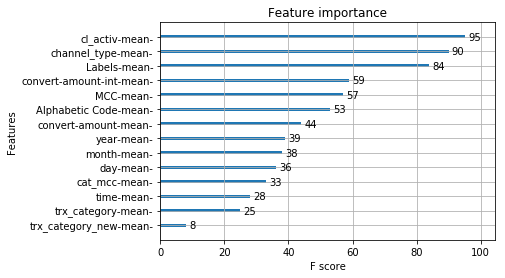

In [77]:
plot_importance(clf)

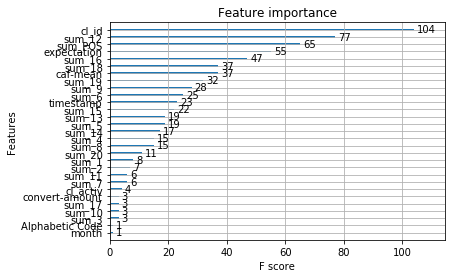

In [76]:
plot_importance(clf)